# Task 4: ANN Modeling with KERAS

Members: Lars Olav Thorbjørnsen, Stein Are Årsnes og Sanjai Vijeyaratnam

### Abstract

This part of the project aims to create an Artificial Neural Network (ANN) machine learning algorithm to model and predict the Vp values based on the the different DEN, Vs and NEU values we have. By creating three layers with five nodes each, the goal will be to have the model learn from the data and it's mistakes to improve and predict better. 
We use the cleaned data, splitting it into two different parts so we can first train it, feeding it data so it can learn the patterns of it. Then we test it, letting it make a prediction before feeding it the actual results, letting it use back-propogation to improve. From our findings, it seems the model is fairly accurate, but it does overshoot, usually predicting a higher value than the actual results. It does still follow the pattern and trend of the data, proving that it is able to see the pattern of the data after training. 

### Introduction

Artificial Neural Network (ANN) are machine learning algorithms that contains layers and nodes to analyze and learn patterns in data. Similar to the brain and it's nervous system, ANN uses nodes to recieve input, analyze it, then pass it on to other nodes in the next layer, continuing this process until it arrives at a estimate. Then it will get the actual result and use back-propagation, a way of using the result to see where it went wrong and improve, fine tuning its findings to become better. 

In this part, we will find the Compressional Wave Velocity (Vp) based on data consisting of Shear Wave Velocity (Vs), Bulk Density (DEN), and Neutron Porosity (NEU) using ANN, so that we can make accurate predictions without worrying about mapping or using reggresion functions. We will use the pre-processed data to train and test the algorithm, hoping that its three layers will suffice in allowing it to learn the pattern of the data. We will then compare it to the actual results of the Vp to see how well it did. 

In [18]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error, r2_score 

Importing the necessary data to create the ANN model

In [19]:
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU

CleanedData = pd.read_excel('CleanedFeatureSelectedFiltered.xlsx')

TargetVariable = ['Vp']
Predictors = [['Vs'], ['DEN'], ['NEU'], 
              ['Vs', 'DEN'], ['Vs', 'NEU'], ['DEN', 'NEU'], 
              ['Vs', 'DEN', 'NEU']]

optimizers = ['adam', 'rmsprop']
activation_functions = {
    'relu': 'relu',
    'leaky_relu': LeakyReLU(alpha=0.1), 
    'swish': 'swish'
}

def create_ann_model(input_dim, optimizer, activation):
    model = Sequential()
    
    model.add(Dense(units=5, input_dim=input_dim, kernel_initializer='normal', activation=activation))
    
    model.add(Dense(units=5, kernel_initializer='normal', activation=activation))
    
    model.add(Dense(1, kernel_initializer='normal'))
    
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    
    return model

results = {}

for predictor_set in Predictors:
    X = CleanedData[predictor_set].values
    y = CleanedData[TargetVariable].values
    
    PredictorScaler = StandardScaler()
    TargetVarScaler = StandardScaler()
    
    X = PredictorScaler.fit_transform(X)
    y = TargetVarScaler.fit_transform(y)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    for opt in optimizers:
        for act_name, act in activation_functions.items():
            model_name = f"{predictor_set}_{opt}_{act_name}"
            
            model = create_ann_model(input_dim=X_train.shape[1], optimizer=opt, activation=act)
          
            history = model.fit(X_train, y_train, batch_size=32, epochs=500, verbose=0)
            
            test_loss = model.evaluate(X_test, y_test, verbose=0)
            
            predictions = model.predict(X_test)
            r2 = r2_score(y_test, predictions)
            
            results[model_name] = r2
            print(f"Model: {model_name}, R2 Score: {r2}")

model_names = list(results.keys())
r2_scores = list(results.values())

plt.figure(figsize=(12, 8), dpi=120)
plt.barh(model_names, r2_scores, color='skyblue')

plt.xlabel('R² Score')
plt.ylabel('Model (Predictors + Optimizer + Activation Function)')
plt.title('R² Scores for Different Predictor Combinations, Optimizers, and Activation Functions')

plt.tight_layout()
plt.show()


KeyboardInterrupt: 

This code standardizes the input data and splits it into training and testing sets. We then create a ANN model with three layers: the first two hidden layers each have 5 nodes and use the ReLU activation function to capture non-linear relationships. The output layer predicts a single value (Vp). The model is compiled with the Adam optimizer and trained using mean squared error as the loss function. After training for 500 epochs, we evaluate the model on the test set and print the test loss to assess its performance.

In [20]:
import pandas as pd

results_df = pd.DataFrame(list(results.items()), columns=['Model', 'R2_Score'])

results_df = results_df.sort_values(by='R2_Score', ascending=False)

print(results_df)

Empty DataFrame
Columns: [Model, R2_Score]
Index: []


Looking at the table above, we can observe the predicted values (Predicted Range) compared to the actual values (Range). Overall, the model's predictions are relatively accurate, with small differences between the actual and predicted values in most cases. Typically, the difference falls between 0.01 to 0.1, which indicates that the model has learned the underlying patterns in the data fairly well.
We do see that it still can have fairly big differences, as in row 2 and 16, but with further training and testing this could improve. Nonetheless, we do show here that the ANN model can be a great solution when the data is difficult to map. 

In [21]:
best_model_name = results_df.iloc[0]['Model']
worst_model_name = results_df.iloc[-1]['Model']

for model_name in [best_model_name, worst_model_name]:
    predictor_set, optimizer, activation_func = model_name.split('_', 2)
    predictor_set = predictor_set.replace("[", "").replace("]", "").split(", ")
    X = CleanedData[predictor_set].values
    
    X = PredictorScaler.fit_transform(X)
    y = TargetVarScaler.fit_transform(CleanedData[TargetVariable].values)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    model = create_ann_model(input_dim=X_train.shape[1], optimizer=optimizer, activation=activation_func)
    model.fit(X_train, y_train, batch_size=32, epochs=500, verbose=0)
    
    predictions = model.predict(X_test)
    predictions = TargetVarScaler.inverse_transform(predictions)
    y_test_orig = TargetVarScaler.inverse_transform(y_test)

    figure(figsize=(8, 6), dpi=380)
    plt.plot(y_test_orig)
    plt.plot(predictions)
    plt.title(f'ANN Model: {model_name} vs True Measured Dataset')
    plt.ylabel('Predicted/True Values')
    plt.xlabel('# Data Point')
    plt.legend(['True Vp', 'Predicted Vp'], loc='upper left')
    plt.show()

    figure(figsize=(8, 6), dpi=380)
    plt.plot(y_test_orig, y_test_orig, 'r')
    plt.scatter(y_test_orig, predictions)
    plt.ylabel('Predicted Vp')
    plt.xlabel('True Vp')
    plt.legend(['Ideal Trend Line', 'True vs Predicted'], loc='upper left')
    plt.show()


IndexError: single positional indexer is out-of-bounds

The graph does a better job at showing us how the ANN model recognizes the pattern of the data. Even though we see that it overshoots a bit on the values, it follows the trends and flow of the actual results, meaning that it can actually read and understand the data it reads. Proving its usefullness in handling the complex relationships with the values. 

In this plot, we compare the ANN predictions with the true data, seeing how it looks with the ideal trend line. If the ANN model was perfectly accurate, we would have seen all the points directly on the line, but, we still see that the points scatter around the ideal trend line, following it closely. We can therefore again say that our ANN model has done a great job of learning the pattern and predicting accurate results by using the data we provide. 

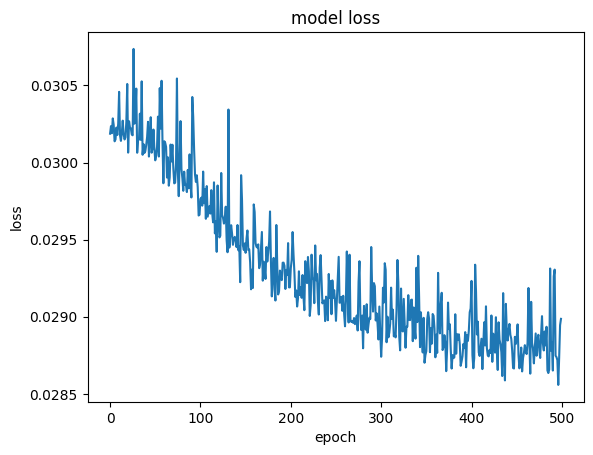

In [ ]:
for model_name in [best_model_name, worst_model_name]:
    predictor_set, optimizer, activation_func = model_name.split('_', 2)
    predictor_set = predictor_set.replace("[", "").replace("]", "").split(", ")
    X = CleanedData[predictor_set].values
    
    X = PredictorScaler.fit_transform(X)
    y = TargetVarScaler.fit_transform(CleanedData[TargetVariable].values)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    model = create_ann_model(input_dim=X_train.shape[1], optimizer=optimizer, activation=activation_func)
    history = model.fit(X_train, y_train, batch_size=32, epochs=500, verbose=0)
    
    plt.plot(history.history['loss'])
    plt.title(f'Model Loss: {model_name}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()


This graph shows how the loss function of the ANN model evolves over the course of training. Loss is essentially the measure of error the model makes in its predictions, and the goal is to minimize it as training progresses.

At the beginning of training, the model starts with a relatively higher loss value of 0.0305, meaning that its initial predictions are less accurate. As the training progresses and the model adjusts its weights based on the backpropagation of errors, the loss steadily decreases, reaching around 0.0290 by the 500th epoch. This decline in loss demonstrates that the model is improving its ability to predict the target variable (Vp) more accurately over time.


### Reflections

### Conclusion

In conclusion, this part of the project successfully demonstrated the ability of an Artificial Neural Network (ANN) to predict Vp values based on the predictor variables Vs, DEN, and NEU. By preprocessing the data and applying a three-layer ANN model, we were able to get predictions that are close with the true measured values. The evaluation reflect that the model's predictions are fairly accurate, with a consistent downward trend in training loss over time. 

The results show that the ANN model is capable of learning and improving its predictions with further training. The scatter plot comparing the true values with the predicted values, as well as the comparison of predicted vs actual values, confirms that the model follows the general trend of the data well, though some minor deviations and overshooting were observed.

Overall, this work shows us that the use of neural networks in handling complex, non-linear relationships between input features and target variables, is a great tool for more accurate Vp predictions.

### References

GeeksForGeeks (2024) *Artificial Neural Networks and its Applications* https://www.geeksforgeeks.org/artificial-neural-networks-and-its-applications/

IBM (2024) *What is a neural network?* https://www.ibm.com/topics/neural-networks